# Monthly DFM

In this notebook, I test the capabilities of Chad Fulton's [code](https://github.com/ChadFulton/tsa-notebooks/blob/master/statespace_large_dynamic_factor_models.ipynb), which estimates a monthly dynamic factor model. I apply it to a German dataset consisting of 18 monthly economic indicators, 10 financial variables, 8 survey series, 10 topics, and one quarterly variable (GDP growth, consumption growth, or investment growth). The goal is to forecast the quarterly variable.

In [1]:
%matplotlib inline

import types
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

- Load monthly (36 variables) and quarterly (1 variable) economic and financial indicators.
- Apply transformations to ensure stationarity of the data.

In [2]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, I will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 3:
        column = np.log(column).diff() * 100 * mult
        
    return column

In [3]:
def load_data(vintage, q_var):
    
    # - Monthly data --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'../data/vintages_monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.date.tolist(), freq='M')
    orig_m.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # - Quarterly data --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'../data/vintages_quarterly/{vintage}.csv')
                .dropna(how='all'))
    # Keep the quarterly variable that will be forecasted
    orig_q = orig_q[['date', q_var]]

    # 2. Extract transformation information
    transform_q = orig_q.iloc[0, 1:]
    orig_q = orig_q.iloc[1:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.date.tolist(), freq='Q')
    orig_q.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q)

* Load seven vintages: 2008-01-01 (all data available up to 31 Dec 2007; forecast made on 1 Jan 2008), 2008-01-16, 2008-02-01, 2008-02-16, 2008-03-01, 2008-03-16, and 2008-04-01.

In [4]:
# Load the vintages of data
q_var = 'GDP'
dta = {date: load_data(date, q_var = q_var)
       for date in ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']}

In [5]:
# Print some information about the base dataset
n, k = dta['2008-01-01'].dta_m.shape
start = dta['2008-01-01'].dta_m.index[0]
end = dta['2008-01-01'].dta_m.index[-1]

print(f'For vintage 2008-01-01, there are {k} series and {n} observations,'
      f' over the period {start} to {end}.')

For vintage 2008-01-01, there are 36 series and 204 observations, over the period 1991-01 to 2007-12.


* Load text data

In [6]:
def load_text_data(vintage, q_var, text_type="topics", estimation_period="2007", num_topics="200", source = "all"):
    
    # 1. Download data
    filename = f'../data/vintages_monthly_{q_var}_{text_type}_{estimation_period}_{num_topics}_{source}/{vintage}.csv'
    orig_text = pd.read_csv(filename).dropna(how='all')
    
    # 2. Extract transformation information
    transform_text = orig_text.iloc[0, 1:]
    orig_text = orig_text.iloc[1:]
    
    # 3. Extract the date as an index
    orig_text.index = pd.PeriodIndex(orig_text.date.tolist(), freq='M')
    orig_text.drop('date', axis=1, inplace=True)
    
    # 4. Apply the transformations
    dta_text = orig_text.apply(transform, axis=0, transforms=transform_text)
    
     # - Output datasets 
    return types.SimpleNamespace(
        orig_text=orig_text, 
        dta_text=dta_text, 
        transform_text=transform_text)

In [7]:
# Parameters for the text file
text_type = "topics"           # could also be "topics_BPW" or "topics_uncertainty"
estimation_period = "2007"     # topics estimated on data <=2007, could also be "2018"
num_topics = "200"             # number of topics, could also be "100"
source = "all"                 # "all", "dpa", "hb", "sz", or "welt"

# Loop over each vintage and load the corresponding text data
for date in ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']:
    # Load text data for each vintage
    text_obj = load_text_data(date, q_var=q_var, 
                              text_type=text_type, 
                              estimation_period=estimation_period, 
                              num_topics=num_topics,
                              source = source)
    
    # Merge the monthly economic data (dta_m) with the text data
    dta[date].combined = dta[date].dta_m.merge(text_obj.dta_text, left_index=True, right_index=True, how='outer')

* Effect of transformations on the variables (visualization)

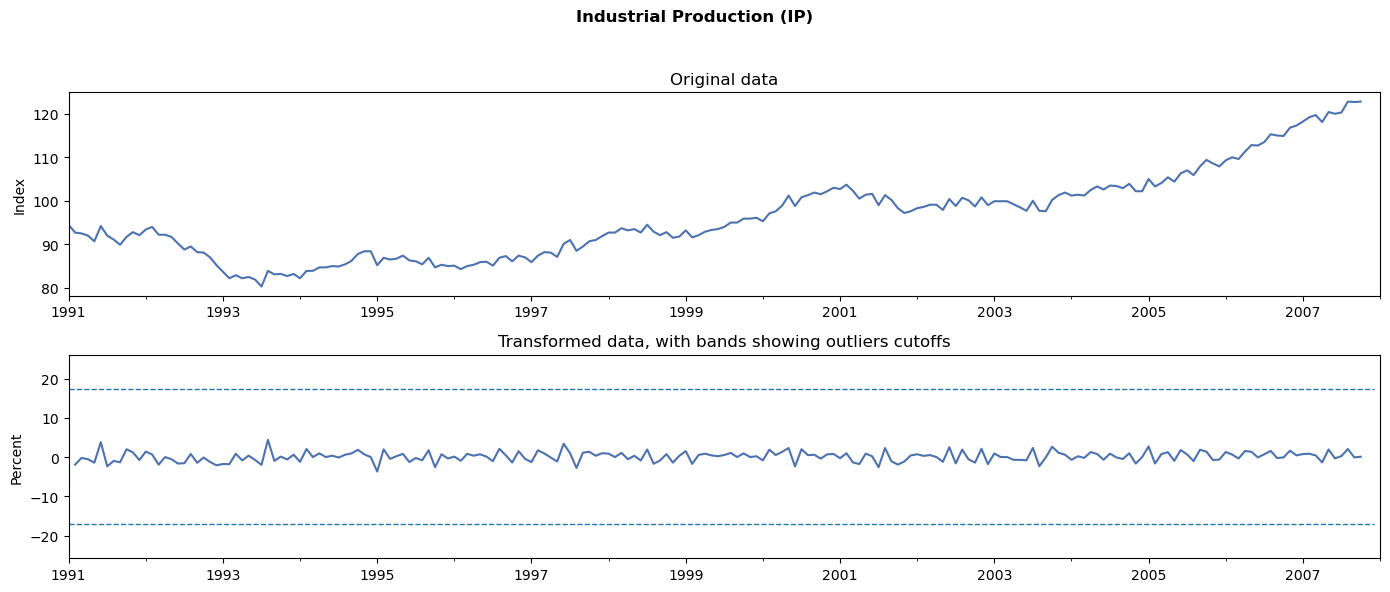

In [8]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 6))

    # Plot the raw data from the 01-Jan 2008 vintage, for:
    # 
    vintage = '2008-01-01'
    variable = 'IP'
    start = '1991-01'
    end = '2007-12'

    # 1. Plot the original dataset, for 1991-01 through 2007-12
    dta[vintage].orig_m.loc[start:end, variable].plot(ax=axes[0])
    axes[0].set(title='Original data', xlim=('1991','2008'), ylabel='Index')

    # 2. Plot the transformed data
    transformed = transform(dta[vintage].orig_m[variable],
                            dta[vintage].transform_m)
    transformed.loc[start:end].plot(ax=axes[1])
    mean = transformed.mean()
    iqr = transformed.quantile([0.25, 0.75]).diff().iloc[1]
    axes[1].hlines([mean - 10 * iqr, mean + 10 * iqr],
                   transformed.index[0], transformed.index[-1],
                   linestyles='--', linewidth=1)
    axes[1].set(title='Transformed data, with bands showing outliers cutoffs',
                xlim=('1991','2008'), ylim=(mean - 15 * iqr, mean + 15 * iqr),
                ylabel='Percent')
    
    fig.suptitle('Industrial Production (IP)',
                 fontsize=12, fontweight=600)

    fig.tight_layout(rect=[0, 0.00, 1, 0.95]);

* Load definitions with full names of the variables and their groups (Activity, Labor market, Prices, Financial, Surveys, and Text)

In [9]:
# Load the definitions Excel file for monthly variables
defn_m = pd.read_excel('../data/data_monthly/variables_definitions.xlsx')
# Set the index to the "Mnemonic" column
defn_m.index = defn_m['Mnemonic']

# Load the definitions Excel file for quarterly variables
defn_q = pd.read_excel('../data/data_quarterly/variables_definitions.xlsx')
defn_q = defn_q[defn_q.Mnemonic == q_var]
defn_q.index = defn_q.Mnemonic

# Load the definitions Excel file for text variables
defn_text = pd.read_excel(f'../data/data_text/variables_definitions_{q_var}_{text_type}_{estimation_period}_{num_topics}_{source}.xlsx')
defn_text.index = defn_text['Mnemonic']

# Combine the definitions for monthly economic and text variables
defn_combined = pd.concat([defn_m, defn_text])

# Display the first few rows
defn_combined.head()

,Mnemonic,Description,Group
Mnemonic,,,
ConstrProd,ConstrProd,Production in main construction industry,Activity
IP,IP,Industrial production index,Activity
ConstrNO,ConstrNO,New orders for main construction industry,Activity
INO,INO,New orders for industry,Activity
ConstrTurn,ConstrTurn,Main construction industry turnover,Activity


* Rename variables in the transformed monthly and quarterly datasets, as well as in the combined monthly dataset (full names)

In [10]:
# Replace the names of the columns in each monthly and quarterly dataset, as well as in the combined dataset
map_m = defn_m['Description'].to_dict()
map_q = defn_q['Description'].to_dict()
map_combined = defn_combined['Description'].to_dict()
for date, value in dta.items():
    value.orig_m.columns = value.orig_m.columns.map(map_m)
    value.dta_m.columns = value.dta_m.columns.map(map_m)
    value.orig_q.columns = value.orig_q.columns.map(map_q)
    value.dta_q.columns = value.dta_q.columns.map(map_q)
    value.combined.columns = value.combined.columns.map(map_combined)

* Dataframe `groups` will contain Mnemonic, Description and Group of each variable

In [11]:
# Get the mapping of variable mnemonic to group name, for monthly variables
groups = defn_combined[['Description', 'Group']].copy()

# Re-order the variables according to the definition file
# (which is ordered by group)
columns = [name for name in defn_combined['Description']
           if name in dta['2008-01-01'].combined.columns]
for date in dta.keys():
    dta[date].combined = dta[date].combined.reindex(columns, axis=1)

# Add our quarterly variable into the "Activity" group
q_var_description = defn_q.loc[q_var, 'Description']
groups.loc[q_var] = {'Description': q_var_description, 'Group': 'Activity'}

# Display the number of variables in each group
(groups.groupby('Group', sort=False)
       .count()
       .rename({'Description': '# series in group'}, axis=1))

,# series in group
Group,
Activity,8
Prices,6
Labor market,5
Financial,10
Surveys,8
Text,10


In [12]:
groups

,Description,Group
Mnemonic,,
ConstrProd,Production in main construction industry,Activity
IP,Industrial production index,Activity
ConstrNO,New orders for main construction industry,Activity
INO,New orders for industry,Activity
ConstrTurn,Main construction industry turnover,Activity
ITurn,Industry turnover,Activity
RetTurn,Retail turnover excluding cars,Activity
CPI,Consumer price index,Prices
CPIEN,"Consumer price index, excluding energy",Prices


## Factor specification

**Global factor(s) only**

In [13]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global']
           for ix, row in groups.iterrows()}

# Check that I have the desired output for "Industrial production index"
print(factors['Industrial production index'])

['Global']


**Global factor(s) and group-specific factors**

In [14]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global', row['Group']]
           for ix, row in groups.iterrows()}

# Check that I have the desired output for "Industrial production index"
print(factors['Industrial production index'])

['Global', 'Activity']


**Global factor(s) and labor market factor**

In [15]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Labor market':
        factors[desc] = ['Global', 'Labor market']
    else:
        factors[desc] = ['Global']

**Global factors(s) and prices factor**

In [16]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Prices':
        factors[desc] = ['Global', 'Prices']
    else:
        factors[desc] = ['Global']

**Global factors(s) and financial factor**

In [17]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Financial':
        factors[desc] = ['Global', 'Financial']
    else:
        factors[desc] = ['Global']

**Global factors(s) and surveys factor**

In [18]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Surveys':
        factors[desc] = ['Global', 'Surveys']
    else:
        factors[desc] = ['Global']

**Global factors(s) and text factor**

In [19]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Text':
        factors[desc] = ['Global', 'Text']
    else:
        factors[desc] = ['Global']

In [20]:
factors

{'Production in main construction industry': ['Global'],
 'Industrial production index': ['Global'],
 'New orders for main construction industry': ['Global'],
 'New orders for industry': ['Global'],
 'Main construction industry turnover': ['Global'],
 'Industry turnover': ['Global'],
 'Retail turnover excluding cars': ['Global'],
 'Consumer price index': ['Global'],
 'Consumer price index, excluding energy': ['Global'],
 'Producer price index': ['Global'],
 'Producer price index, excluding energy': ['Global'],
 'Export price index': ['Global'],
 'Import price index': ['Global'],
 'Hours worked: manufacturing': ['Global'],
 'Hours worked: construction': ['Global'],
 'Employment': ['Global'],
 'Gross wages and salaries: manufacturing and mining': ['Global'],
 'Gross wages and salaries: construction': ['Global'],
 'CDAX': ['Global'],
 'Government bond yields (1-year)': ['Global'],
 'Government bond yields (5-years)': ['Global'],
 'Government bond yields (10-years)': ['Global'],
 'Nominal 

## Number of factors from each group

**Two global factors that evolve together jointly**

In [21]:
factor_multiplicities = {'Global': 2}

## Factor orders

**Two global factors jointly follow VAR(3)**

In [22]:
factor_orders = {'Global': 3}

## The model

* monthly/quarterly mixed frequency model
* AR(1) process for the idiosyncratic disturbance term
* data is standardized

In [23]:
# Get monthly and quarterly datasets
start = '1991-04'
endog_m = dta['2008-01-01'].combined.loc[start:, :]
q_var_description = defn_q.loc[q_var, 'Description']
endog_q = dta['2008-01-01'].dta_q.loc[start:, [q_var_description]]

# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

In [24]:
model.summary()

Model:,Dynamic Factor Model,# of monthly variables:,46
,+ 3 factors in 2 blocks,# of quarterly variables:,1
,+ Mixed frequency (M/Q),# of factor blocks:,2
,+ AR(1) idiosyncratic,Idiosyncratic disturbances:,AR(1)
Sample:,1991-04,Standardize variables:,True
,- 2007-12,,
Dep. variable,Global.1,Global.2,Text
Production in main const...,X,X,
Industrial production in...,X,X,
New orders for main cons...,X,X,
New orders for industry,X,X,


**Estimation**

In [25]:
results = model.fit(disp=10)

EM start iterations, llf=-11082
EM iteration 10, llf=-10910, convergence criterion=3.1299e-05
EM iteration 20, llf=-10909, convergence criterion=9.0448e-06
EM iteration 30, llf=-10908, convergence criterion=4.6211e-06
EM iteration 40, llf=-10907, convergence criterion=2.7232e-06
EM iteration 50, llf=-10907, convergence criterion=1.8175e-06
EM iteration 60, llf=-10907, convergence criterion=1.3119e-06
EM iteration 70, llf=-10907, convergence criterion=1.0008e-06
EM converged at iteration 71, llf=-10907, convergence criterion=9.7641e-07 < tolerance=1e-06


In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        Dynamic Factor Results                                        
======================================================================================================
Dep. Variable:     "Production in main const...", and 46 more   No. Observations:                  201
Model:                                   Dynamic Factor Model   Log Likelihood              -10906.902
                                      + 3 factors in 2 blocks   AIC                          22243.804
                                      + Mixed frequency (M/Q)   BIC                          22954.015
                                        + AR(1) idiosyncratic   HQIC                         22531.186
Date:                                        Fri, 11 Apr 2025   EM Iterations                       71
Time:                                                18:07:25                                         
Sample:                                            04-30-1991                                         
                                                 - 12-31-2007                                         
Covariance Type:                                 Not computed                                         
                                     Observation equation:                                      
================================================================================================
           Factor loadings:   Global.1   Global.2       Text    idiosyncratic: AR(1)        var.
------------------------------------------------------------------------------------------------
Production in main const...       0.03      -0.15          .                   -0.28        0.88
Industrial production in...       0.11      -0.21          .                   -0.41        0.61
New orders for main cons...      -0.01      -0.04          .                   -0.42        0.84
    New orders for industry       0.11      -0.09          .                   -0.47        0.70
Main construction indust...       0.07      -0.13          .                    0.02        0.91
          Industry turnover       0.13      -0.20          .                   -0.43        0.59
Retail turnover excludin...       0.05      -0.04          .                   -0.48        0.75
       Consumer price index       0.02      -0.04          .                    0.12        0.98
Consumer price index, ex...      -0.03       0.01          .                    0.05        0.98
       Producer price index       0.16      -0.12          .                    0.18        0.78
Producer price index, ex...       0.13      -0.10          .                    0.30        0.76
         Export price index       0.21      -0.12          .                    0.24        0.64
         Import price index       0.19      -0.12          .                    0.30        0.69
Hours worked: manufactur...       0.07      -0.15          .                   -0.32        0.79
Hours worked: constructi...       0.03      -0.15          .                   -0.28        0.88
                 Employment       0.12      -0.03          .                    0.50        0.67
Gross wages and salaries...       0.03      -0.02          .                   -0.36        0.87
Gross wages and salaries...       0.04      -0.09          .                   -0.07        0.97
                       CDAX       0.07      -0.08          .                    0.02        0.97
Government bond yields (...       0.27       0.11          .                   -0.09        0.51
Government bond yields (...       0.27       0.19          .                   -0.40        0.37
Government bond yields (...       0.23       0.21          .                   -0.33        0.48
Nominal effective exchan...      -0.10       0.10          .                    0.36        0.81
Nominal effective exchan...      -0.11       0.10          .                    0.36        0.80


## Estimated factors

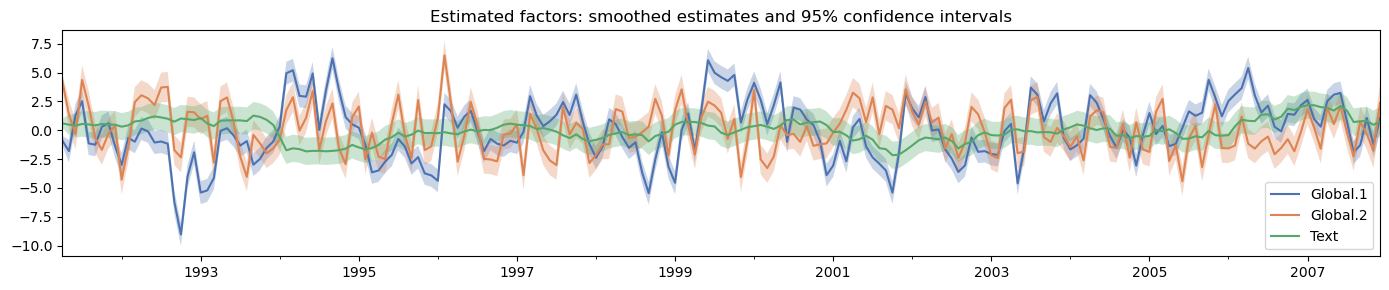

In [27]:
# Get estimates of the global and text factors,
# conditional on the full dataset ("smoothed")
factor_names = ['Global.1', 'Global.2', 'Text']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
var = pd.concat([results.factors.smoothed_cov.loc[name, name]
                for name in factor_names], axis=1)
std = np.sqrt(var)

crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

## Explanatory power of the factors

* The first factor is mainly driven by financial variables, the export price index, ifo climate indicator, and the Crisis topic.
* The second global factor captures activity measures—such as production and turnover—as well as labor market data, ifo indicator, and financial variables.
* The Text factor exclusively loads on text variables and effectively explains variations in Economic Growth, Banking, Crisis and Commodity Markets.

In [28]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:3]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global.1        \
                                        Variable $R^2$   
0  Yields on debt securities issued by residents  0.76   
1                 Yields on bank debt securities  0.75   
2               Yields on public debt securities  0.71   
3               Government bond yields (5-years)  0.51   
4                Government bond yields (1-year)  0.49   
5              Government bond yields (10-years)  0.37   
6               ifo: industry and trade, climate  0.30   
7            Yields on corporate debt securities  0.27   
8                                         Crisis  0.27   
9                             Export price index  0.24   

         Top ten variables explained by Global.2        \
                                        Variable $R^2$   
0               Yields on public debt securities  0.47   
1  Yields on debt securities issued by residents  0.44   
2                 Yields on bank debt securities  0.41   
3              Government bond yields (10-years)  0.22   
4               Government bond yields (5-years)  0.20   
5                    Industrial production index  0.16   
6            Yields on corporate debt securities  0.16   
7                              Industry turnover  0.13   
8     ifo: industry and trade, current situation  0.12   
9                    Hours worked: manufacturing  0.09   

           Top ten variables explained by Text        
                                      Variable $R^2$  
0                              Economic Growth  0.40  
1                                      Banking  0.29  
2                                       Crisis  0.24  
3                            Commodity Markets  0.18  
4                              Policy Measures  0.14  
5                              Problem Solving  0.11  
6                             Corporate Growth  0.02  
7                                  US Politics  0.00  
8           Media Coverage of Plans and Rumors  0.00  
9  Steel Industry Restructuring and Downsizing  0.00

In [29]:
rsquared

,Global.1,Global.2,Text
Production in main construction industry,0.008462,3.984063e-02,NaN
Industrial production index,0.072411,1.649238e-01,NaN
New orders for main construction industry,0.000456,3.820645e-03,NaN
New orders for industry,0.076622,1.679895e-02,NaN
Main construction industry turnover,0.027529,3.800619e-02,NaN
Industry turnover,0.111392,1.272481e-01,NaN
Retail turnover excluding cars,0.006984,4.146887e-03,NaN
Consumer price index,0.000024,1.308142e-03,NaN
"Consumer price index, excluding energy",0.009386,1.995461e-03,NaN
Producer price index,0.116384,2.227965e-02,NaN


## Plotting R^2

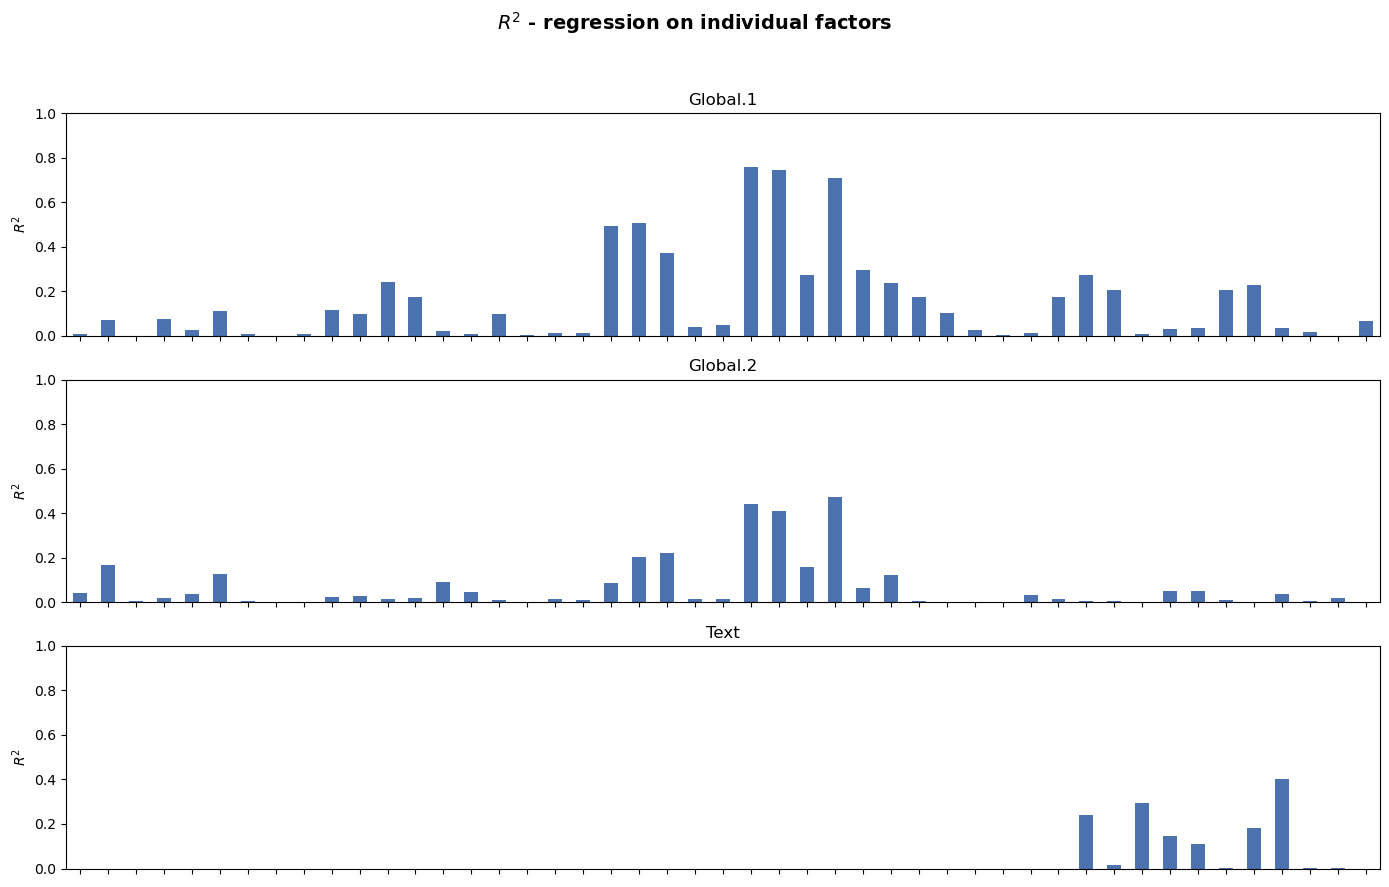

In [30]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

**Explanatory value of all factors to a given variable**

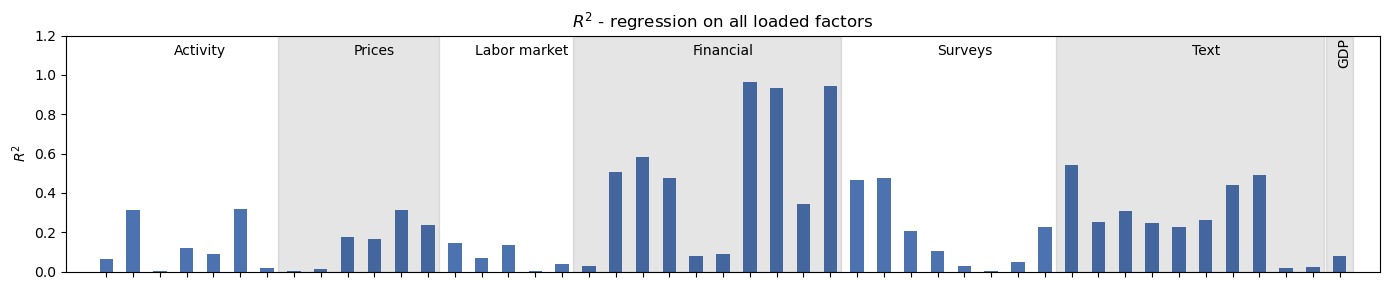

In [31]:
group_counts = defn_combined[['Description', 'Group']]
group_counts = group_counts[group_counts['Description'].isin(dta['2008-01-01'].combined.columns)]
group_counts = group_counts.groupby('Group', sort=False).count()['Description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i]
        n = end - start
        text = group_counts.index[i]
        #if len(text) > n:
        #    text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for a quarterly variable
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate(q_var, (model.k_endog - 1.1, 1.05), ha='left', rotation=90)
    ax.fill_between(np.arange(model.k_endog-1, model.k_endog+1)-0.5, 0, 1.2, color='k', alpha=0.1)
    
    fig.tight_layout();

## Forecasting

* forecast method -> point forecasts only

In [32]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

                                            2008-01   2008-02   2008-03
Production in main construction industry  -0.471337  0.246039 -0.075765
Industrial production index                0.117495  0.282129  0.149426
New orders for main construction industry -1.841792  0.646777 -0.352238
New orders for industry                    0.030144  0.504184  0.153986
Main construction industry turnover       -0.431107  0.073697 -0.325412


In [33]:
# The date of the final forecast
results.forecast('2008-03').T

,2008-01,2008-02,2008-03
Production in main construction industry,-0.471337,0.246039,-0.075765
Industrial production index,0.117495,0.282129,0.149426
New orders for main construction industry,-1.841792,0.646777,-0.352238
New orders for industry,0.030144,0.504184,0.153986
Main construction industry turnover,-0.431107,0.073697,-0.325412
Industry turnover,0.205293,0.396185,0.239018
Retail turnover excluding cars,0.352045,-0.061101,0.096767
Consumer price index,0.120418,0.172663,0.172988
"Consumer price index, excluding energy",0.150170,0.154714,0.156168
Producer price index,0.183269,0.154579,0.126678


* get_forecast method gives confidence intervals

In [34]:
# point forecast
results.get_forecast('2008-03').predicted_mean[q_var_description]

2008-01    1.593402
2008-02    1.236768
2008-03    1.445624
Freq: M, Name: Gross Domestic Product, dtype: float64

In [35]:
# lower bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['lower ' + q_var_description]]

,lower Gross Domestic Product
2008-01,-2.430162
2008-02,-2.841118
2008-03,-2.702186


In [36]:
# upper bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['upper '+ q_var_description]]

,upper Gross Domestic Product
2008-01,5.616967
2008-02,5.314653
2008-03,5.593433


* predict and get_prediction are more general => in-sample and out-of-sample forecasts

In [37]:
prediction_results = results.get_prediction(start='1991-04', end='2008-03')

In [38]:
prediction_results.predicted_mean[q_var_description]

1991-04    -6.790452
1991-05   -12.986183
1991-06    -3.114753
1991-07    -4.273041
1991-08     3.463064
             ...    
2007-11     2.163291
2007-12     1.617846
2008-01     1.593402
2008-02     1.236768
2008-03     1.445624
Freq: M, Name: Gross Domestic Product, Length: 204, dtype: float64

In [39]:
ci = prediction_results.conf_int(alpha=0.05)

In [40]:
ci[['upper ' + q_var_description]]

,upper Gross Domestic Product
1991-04,-3.408085
1991-05,-10.392430
1991-06,-0.801098
1991-07,-2.494352
1991-08,6.500759
...,...
2007-11,5.554798
2007-12,5.648290
2008-01,5.616967
2008-02,5.314653


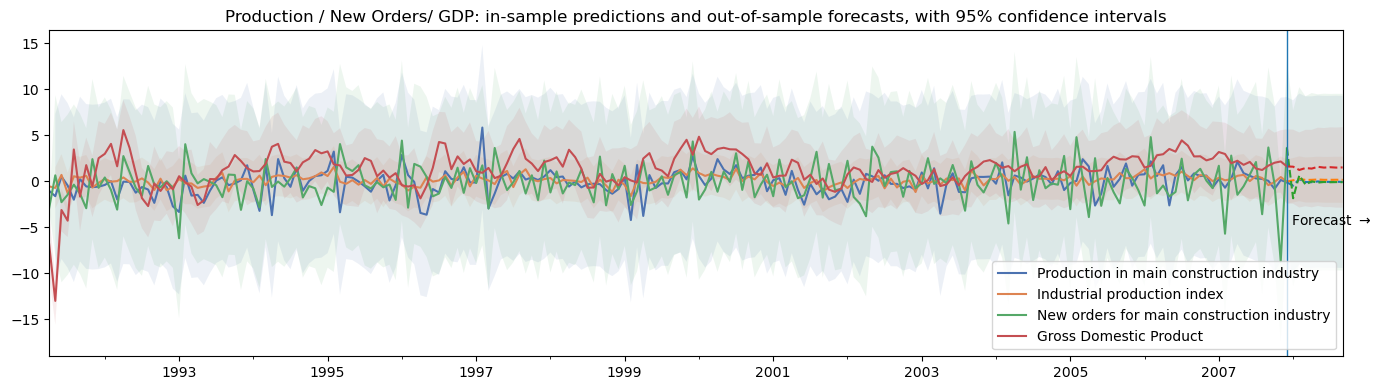

In [41]:
# Create forecasts results objects, through the end of 2008-09
prediction_results = results.get_prediction(start='1991-04', end='2008-09')

variables = ['Production in main construction industry',
             'Industrial production index',
             'New orders for main construction industry',
             'Gross Domestic Product']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2007-12'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2007-12':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2', 'C3'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2007-12', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2007-12', -4.7))
    ax.set(title=('Production / New Orders/ GDP:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

## GDP forecast

In [42]:
# Compute the point forecasts
#fcast_q = results.forecast('2009-12')[q_var_description].resample('Q').last()
fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[q_var_description].resample('Q').last()

C:\Users\mokuneva.UNI-KIEL\AppData\Local\Temp\2\ipykernel_5672\520806084.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[q_var_description].resample('Q').last()


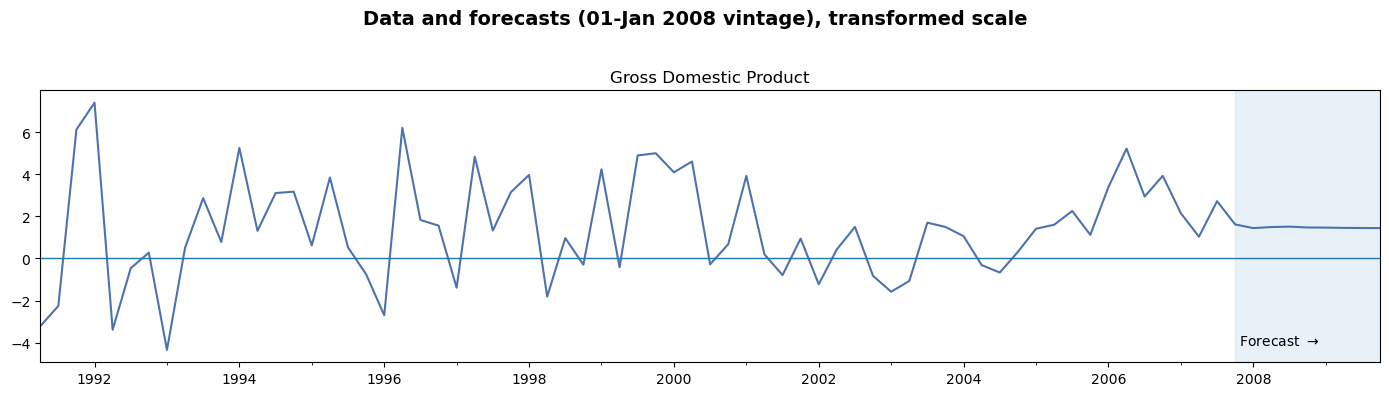

In [43]:
# For more convenient plotting, combine the observed data with the forecasts
plot_q = pd.concat([dta['2008-01-01'].dta_q.loc['1991-04':'2007-09', q_var_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(1, figsize=(14, 4))

    # Plot quarterly variable (growth), data and forecasts
    plot_q.plot(ax=axes)
    axes.set(title=q_var_description)
    axes.hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)
    
    # Show the forecast period
    ylim = axes.get_ylim()
    axes.fill_between(plot_q.loc['2007-10':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
    axes.annotate(r' Forecast $\rightarrow$',
                         ('2007-10', ylim[0] + 0.1 * ylim[1]))
    axes.set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (01-Jan 2008 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

## Original GDP forecast (2008-01-01 vintage)

In [44]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('2008-03')[q_var_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (1st of January 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of January 2008) forecast for real GDP growth in 2008Q1: 1.45%


C:\Users\mokuneva.UNI-KIEL\AppData\Local\Temp\2\ipykernel_5672\646263151.py:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  point_forecasts_q = point_forecasts_m.resample('Q').last()


In [45]:
# The original point forecasts are monthly
point_forecasts_m = results.get_prediction(start='2008-03', end='2008-03').predicted_mean[q_var_description]

print('Baseline (1st of January 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of January 2008) forecast for real GDP growth in 2008Q1: 1.45%


## Updated GDP forecast: Jan16 2008 vintage

In [46]:
# Since I will be collecting results for a number of vintages,
# construct a dictionary to hold them, and include the baseline
# results from 01-Jan 2008
vintage_results = {'2008-01-01': results}

# Get the updated monthly and quarterly datasets
start = '1991-04'
updated_endog_m = dta['2008-01-16'].combined.loc[start:, :]
q_var_description = defn_q.loc[q_var, 'Description']
updated_endog_q = dta['2008-01-16'].dta_q.loc[start:, [q_var_description]]

# Get the results for Mid Jan 2008 using `apply`
vintage_results['2008-01-16'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)

In [47]:
# Print the updated forecast for real GDP growth in 2008Q1
updated_forecasts_q = (
    vintage_results['2008-01-16'].forecast('2008-03')[q_var_description]
                              .resample('Q').last())

print('Mid Jan 2008 forecast for real GDP growth in 2008Q1:'
      f' {updated_forecasts_q["2008Q1"]:.2f}%')

Mid Jan 2008 forecast for real GDP growth in 2008Q1: 1.38%


C:\Users\mokuneva.UNI-KIEL\AppData\Local\Temp\2\ipykernel_5672\4218428434.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  vintage_results['2008-01-16'].forecast('2008-03')[q_var_description]


## Updated GDP forecast: 01Jan2008 - 01Apr 2008 vintages

In [48]:
# Apply our results to the remaining vintages
for vintage in ['2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']:
    # Get updated data for the vintage
    updated_endog_m = dta[vintage].combined.loc[start:, :]
    updated_endog_q = dta[vintage].dta_q.loc[start:, [q_var_description]]

    # Get updated results for for the vintage
    vintage_results[vintage] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)

In [49]:
# Compute forecasts for each vintage
forecasts = {vintage: res.get_prediction(start='2008-03', end='2008-03').predicted_mean[q_var_description].loc['2008-03']
             for vintage, res in vintage_results.items()}
# Convert to a Pandas series with a date index
forecasts = pd.Series(list(forecasts.values()),
                      index=pd.PeriodIndex(forecasts.keys(), freq='D'))
    
# Print our forecast for 2008Q1 real GDP growth across all vintages
for vintage, value in forecasts.items():
    print(f'{vintage} forecast for real GDP growth in 2008Q1:'
          f' {value:.2f}%')

2008-01-01 forecast for real GDP growth in 2008Q1: 1.45%
2008-01-16 forecast for real GDP growth in 2008Q1: 1.38%
2008-02-01 forecast for real GDP growth in 2008Q1: 1.25%
2008-02-16 forecast for real GDP growth in 2008Q1: 1.42%
2008-03-01 forecast for real GDP growth in 2008Q1: 1.89%
2008-03-16 forecast for real GDP growth in 2008Q1: 2.23%
2008-04-01 forecast for real GDP growth in 2008Q1: 2.56%


## News

In [50]:
# Compute the news and impacts on the real GDP growth forecast
# for 2008Q1, between 2008-01-01 and 2008-01-16 vintages
news = vintage_results['2008-01-16'].news(
    vintage_results['2008-01-01'], impact_date='2008-03',
    impacted_variable=q_var_description,
    comparison_type='previous')

# The `summary` method summarizes all updates. Here I am not
# showing it, to save space.
news.summary()

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     0.09
1    -0.90
2    -0.46
3     3.39
4    -0.74
5    -1.33
6    -0.40
Name: observed, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 2:] = data.iloc[:, 2:].map(
X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     0.02
1     0.53
2     0.20
3    -1.27
4     1.46
5     1.24
6    -0.20
Name: forecast (prev), dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 2:] = data.iloc[:, 2:].map(
X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      News                                     
===============================================================================
Model:                DynamicFactorMQ   Original sample:                1991-04
Date:                Fri, 11 Apr 2025                                 - 2007-12
Time:                        18:09:00   Update through:                 2007-12
                                        # of revisions:                      67
                                        # of new datapoints:                  7
                 Impacts for [impacted variable = Gross Domestic Product]                 
==========================================================================================
impact date estimate (prev) impact of revisions impact of news total impact estimate (new)
------------------------------------------------------------------------------------------
    2008-03            1.45                0.00          -0.06        -0.06           1.38
                              News from updated observations:                              
===========================================================================================
update date                         updated variable   observed forecast (prev)        news
-------------------------------------------------------------------------------------------
    2007-11                               Employment       0.09            0.02        0.07
                         Industrial production index      -0.90            0.53       -1.42
                                   Industry turnover      -0.46            0.20       -0.66
                             New orders for industry       3.39           -1.27        4.66
            Production in main construction industry      -0.74            1.46       -2.20
                      Retail turnover excluding cars      -1.33            1.24       -2.57
    2007-12            Economics Sentiment Indicator      -0.40           -0.20       -0.20
===========================================================================================
"""

In [51]:
# I can re-arrange the `details_by_impact` table to show the new
# observations with the top ten impacts (in absolute value)
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)

observed  \
update date updated variable                                     
2007-11     New orders for industry                       3.39   
            Industrial production index                  -0.90   
            Industry turnover                            -0.46   
            Retail turnover excluding cars               -1.33   
            Production in main construction industry     -0.74   
2007-12     Economics Sentiment Indicator                -0.40   
2007-11     Employment                                    0.09   

                                                      forecast (prev)  news  \
update date updated variable                                                  
2007-11     New orders for industry                             -1.27  4.66   
            Industrial production index                          0.53 -1.42   
            Industry turnover                                    0.20 -0.66   
            Retail turnover excluding cars                       1.24 -2.57   
            Production in main construction industry             1.46 -2.20   
2007-12     Economics Sentiment Indicator                       -0.20 -0.20   
2007-11     Employment                                           0.02  0.07   

                                                      weight  impact  
update date updated variable                                          
2007-11     New orders for industry                     0.01    0.07  
            Industrial production index                 0.04   -0.06  
            Industry turnover                           0.05   -0.03  
            Retail turnover excluding cars              0.01   -0.02  
            Production in main construction industry    0.00   -0.01  
2007-12     Economics Sentiment Indicator               0.03   -0.01  
2007-11     Employment                                  0.10    0.01

**All vintages**

In [52]:
news_results = {}
vintages = ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']
impact_date = '2008-03'

for i in range(1, len(vintages)):
    vintage = vintages[i]
    prev_vintage = vintages[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (2008-01-01) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable=q_var_description,
        comparison_type='previous')

In [53]:
news_results['2008-04-01'].details_by_impact

observed  \
impact date impacted variable      update date updated variable                                                
2008-03     Gross Domestic Product 2008-01     Gross wages and salaries: construction               3.642154   
                                               Gross wages and salaries: manufacturing and mining  -0.054815   
                                               Hours worked: construction                          10.558428   
                                               Hours worked: manufacturing                         -0.914785   
                                               Main construction industry turnover                 14.978536   
                                               New orders for main construction industry           18.747448   
                                   2008-02     Export price index                                   0.462322   
                                               Import price index                                   0.892067   
                                               Producer price index                                 0.572599   
                                               Producer price index, excluding energy               0.444643   
                                   2008-03     Banking                                             -0.000901   
                                               CDAX                                                -3.106678   
                                               Commodity Markets                                    0.000808   
                                               Consumer price index                                 0.377715   
                                               Corporate Growth                                     0.001009   
                                               Crisis                                               0.000715   
                                               Economic Growth                                     -0.002309   
                                               Economics Sentiment Indicator                       -0.300000   
                                               GfK: business cycle expectations                     0.400000   
                                               GfK: consumer climate indicator                      0.100000   
                                               GfK: income expectations                             2.000000   
                                               GfK: willigness-to-buy                               4.800000   
                                               Government bond yields (1-year)                      0.230000   
                                               Government bond yields (10-years)                    0.020000   
                                               Government bond yields (5-years)                     0.230000   
                                               Media Coverage of Plans and Rumors                  -0.000008   
                                               Nominal effective exchange rate (broad)              2.895329   
                                               Nominal effective exchange rate (narrow)             2.408879   
                                               Policy Measures                                     -0.001593   
                                               Problem Solving                                     -0.000498   
                                               Steel Industry Restructuring and Downsizing         -0.001069   
                                               US Politics                                          0.001037   
                                               Yields on bank debt securities                       0.000000   
                                               Yields on corporate debt securities                 -0.030000   
                                               Yields on debt securi

## Impacts by group

In [54]:
group_impacts = {'2008-01-01': None}

for vintage, news in news_results.items():
    # Start from the details by impact table
    details_by_impact = (
        news.details_by_impact.reset_index()
            .drop(['impact date', 'impacted variable'], axis=1))
    
    # Merge with the groups dataset, so that we can identify
    # which group each individual impact belongs to
    impacts = (pd.merge(details_by_impact, groups, how='left',
                        left_on='updated variable', right_on='Description')
                 .drop('Description', axis=1)
                 .set_index(['update date', 'updated variable']))

    # Compute impacts by group, summing across the individual impacts
    group_impacts[vintage] = impacts.groupby('Group').sum()['impact']

# Add in a row of zeros for the baseline forecast
group_impacts['2008-01-01'] = group_impacts['2008-01-16'] * np.nan

# Convert into a Pandas DataFrame, and fill in missing entries
# with zeros (missing entries happen when there were no updates
# for a given group in a given vintage)
group_impacts = (
    pd.concat(group_impacts, axis=1)
      .fillna(0)
      .reindex(group_counts.index).T)
group_impacts.index = forecasts.index

# Print the table of impacts from data in each group,
# along with a row with the "Total" impact
#(group_impacts.T
#    .append(group_impacts.sum(axis=1).rename('Total impact on 2020Q2 forecast'))
#    .round(2).iloc[:, 1:])

pd.concat(
    [
        group_impacts.T,
        group_impacts.sum(axis=1).rename('Total impact on 2008Q1 forecast').to_frame().T
    ],
    axis=0
).round(2).iloc[:, 1:]

,2008-01-16,2008-02-01,2008-02-16,2008-03-01,2008-03-16,2008-04-01
Activity,-0.06,-0.02,0.05,-0.00,0.23,0.08
Prices,0.00,-0.00,0.00,0.47,0.00,0.22
Labor market,0.01,-0.01,0.10,0.05,0.00,0.05
Financial,0.00,0.00,0.00,-0.05,0.00,0.01
Surveys,-0.01,0.14,0.00,-0.00,0.00,0.09
Text,0.00,-0.24,0.00,-0.02,0.00,0.04
Total impact on 2008Q1 forecast,-0.06,-0.13,0.15,0.45,0.24,0.49


**Impacts by group: graphical illustration**

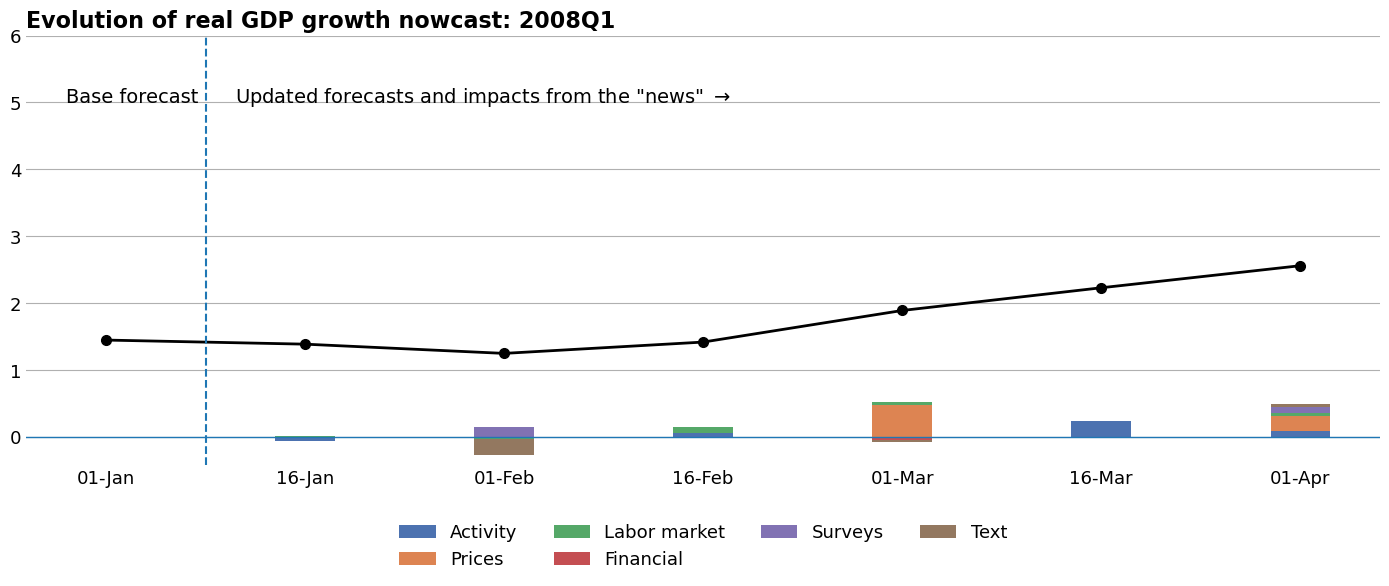

In [55]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Stacked bar plot showing the impacts by group
    group_impacts.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax)

    # Line plot showing the forecast for real GDP growth in 2008Q1 for each vintage
    x = np.arange(len(forecasts))
    ax.plot(x, forecasts, marker='o', color='k', markersize=7, linewidth=2)
    ax.hlines(0, -1, len(group_impacts) + 1, linewidth=1)

    # x-ticks
    labels = group_impacts.index.strftime('%d-%b')
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)
    
    # y-ticks
    ax.set_ylim(top=6)
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Evolution of real GDP growth nowcast: 2008Q1', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]

    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 5, linestyles='--')
    ax.annotate('Base forecast', (-0.2, 5), fontsize=14)
    ax.annotate(r'Updated forecasts and impacts from the "news" $\rightarrow$', (0.65, 5), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout()